In [5]:
import os
import cmdstanpy
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import describe, gaussian_kde, norm, expon
import multiprocessing
import seaborn as sns
import warnings
import time
import pandas as pd

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 14

In [128]:
from thinning import sample_hawkes_process_thinning_true_vectorised
from utils import exp_kernel_vectorised, constant_background, plot_counting_process
from mle import log_likelihood, optimise_params
from utils import trace_plots, posterior_histograms, posterior_kdes_overlaid, stacked_credible_intervals

In [80]:
file_path = r"C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\guinea_first_800.csv"

In [81]:
df = pd.read_csv(file_path)

In [82]:
df.head()

,date
0,01/01/2014
1,01/01/2014
2,06/01/2014
3,06/01/2014
4,11/01/2014


In [83]:
from datetime import datetime

def date_to_number(date_str, date_format='%d/%m/%Y'):
    # Parse the date string into a datetime object
    date_object = datetime.strptime(date_str, date_format)
    
    # Define a reference date
    reference_date = datetime(1900, 1, 1)
    
    # Calculate the difference in days between the date and the reference date
    delta = date_object - reference_date
    
    # Return the number of days
    return delta.days

In [84]:
df['date_number'] = df['date'].apply(date_to_number)

In [85]:
df.head()

,date,date_number
0,01/01/2014,41638
1,01/01/2014,41638
2,06/01/2014,41643
3,06/01/2014,41643
4,11/01/2014,41648


In [86]:
first_number = df['date_number'].iloc[0]
df['date_number'] = df['date_number'] - first_number

In [87]:
df.head()

,date,date_number
0,01/01/2014,0
1,01/01/2014,0
2,06/01/2014,5
3,06/01/2014,5
4,11/01/2014,10


In [88]:
df['date_number'].values

array([  0,   0,   5,   5,  10,  14,  19,  24,  28,  31,  32,  33,  33,
        34,  34,  37,  39,  41,  46,  47,  48,  49,  51,  51,  53,  54,
        54,  55,  55,  57,  57,  59,  59,  59,  59,  59,  59,  59,  59,
        59,  59,  60,  60,  61,  61,  63,  64,  65,  65,  65,  65,  66,
        67,  68,  68,  68,  69,  69,  69,  70,  70,  70,  70,  70,  70,
        70,  70,  70,  70,  71,  71,  71,  71,  72,  72,  72,  72,  73,
        73,  73,  73,  74,  74,  74,  75,  76,  77,  77,  77,  78,  78,
        78,  78,  79,  79,  79,  79,  80,  80,  80,  80,  80,  80,  81,
        81,  81,  81,  82,  82,  82,  82,  82,  82,  83,  83,  83,  83,
        83,  83,  84,  84,  84,  85,  85,  85,  86,  86,  87,  87,  87,
        87,  87,  88,  88,  88,  88,  88,  88,  88,  88,  90,  90,  90,
        91,  92,  92,  92,  94,  95,  95,  95,  95,  95,  95,  96,  96,
        96,  96,  97,  97,  97,  97,  97,  97,  97,  97,  97,  98,  98,
        98,  98,  98,  98,  98,  99,  99,  99,  99,  99, 100, 10

In [121]:
def interpolate_days(date_numbers_original):
    date_numbers = date_numbers_original.astype('float64').copy()
    current_number = date_numbers[0]
    current_index = 0
    count = 1
    for i, number in enumerate(date_numbers[1:], start=1):
        if number == current_number:
            count += 1
        else:
            date_numbers[current_index: current_index+count] += np.arange(0, 1, 1/count)
            current_number = number
            current_index = i
            count = 1
    return date_numbers

In [124]:
date_numbers_interpolated = interpolate_days(df['date_number'].values)

In [126]:
date_numbers_interpolated[-5:]

array([240.6, 240.7, 240.8, 240.9, 241. ])

In [135]:
max_T = date_numbers_interpolated[-1]+1

In [136]:
data = date_numbers_interpolated, max_T
initial_guess = [0.5, 0.5, 0.5]
current_params, _ = optimise_params(data, initial_guess, 1e-6)

In [137]:
current_params

array([0.36832591, 0.52377253, 0.57994229])

In [138]:
stan_file = os.path.join('.', 'bayesian_clean', 'models', 'exponential_priors.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

In [145]:
param_strings = ['mu', 'alpha', 'delta']

In [139]:
data = {
    "N": len(date_numbers_interpolated),
    "events_list": date_numbers_interpolated,
    "max_T": max_T             
}

In [142]:
warmup=250
fit = model_compiled.sample(data=data,
                                seed=123,
                                chains=2,
                                parallel_chains=2,
                                iter_warmup=warmup,
                                iter_sampling=3*warmup,
                                inits="0",
                                save_warmup=True)

23:22:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

23:47:43 - cmdstanpy - INFO - CmdStan done processing.


In [143]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,436.535000,0.059193,1.301380,433.935000,436.851000,437.991000,483.36,0.238746,1.004190
mu,0.392197,0.004410,0.104044,0.227410,0.387585,0.575392,556.60,0.274922,1.002990
alpha,0.540662,0.004818,0.094142,0.397916,0.535196,0.707641,381.86,0.188612,0.999800
delta,0.604796,0.005851,0.113198,0.432019,0.599686,0.796912,374.32,0.184888,0.999866


In [144]:
print(fit.diagnose())

Processing csv files: C:\Users\ethan\AppData\Local\Temp\tmpyx6bm6rm\exponential_priorsclv7i2p4\exponential_priors-20240425232215_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\AppData\Local\Temp\tmpyx6bm6rm\exponential_priorsclv7i2p4\exponential_priors-20240425232215_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



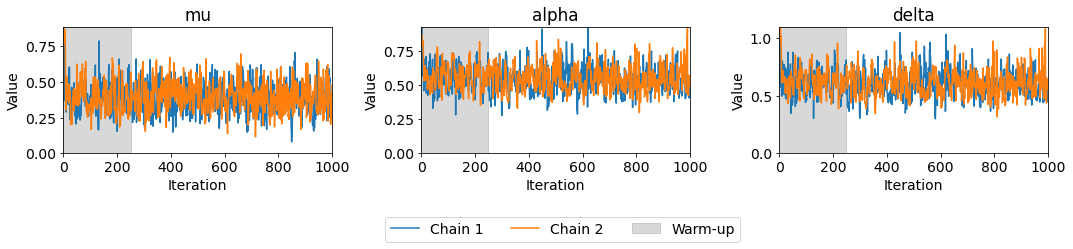

In [149]:
trace_plots([fit], param_strings, warmup=250)

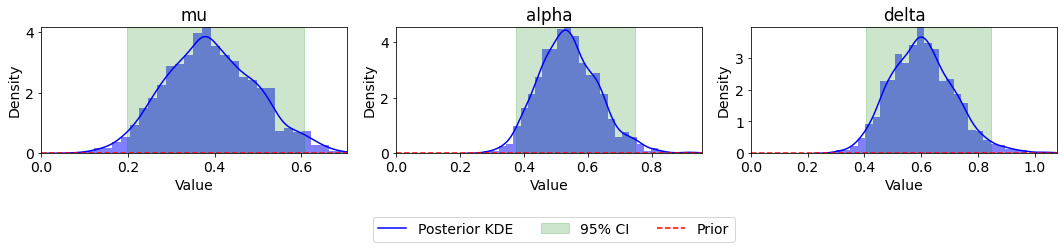

In [150]:
posterior_histograms([fit], param_strings, [lambda x: expon.pdf(x, scale=1/0.01)]*3)

In [155]:
save_dir = os.path.join('.', 'data_fitting')
save_dir

'.\\data_fitting'

In [156]:
save_path = os.path.join(save_dir, 'guinea_exp_priors')

In [157]:
fit.save_csvfiles(save_path)